# **Librerie per la rappresentazione delle molecole e il calcolo dei descrittori**

In questo notebook si presenta in maniera concisa l'utilizzo della libreria `rdkit` per interpretate la rappresentazione SMILES delle molecole e la libreria `mordred` per il calcolo di descrittori molecolari. Si farà uso della libreria `pandas` per gestire il database di informazioni. Infine, si utilizzerà `py3Dmol` per rappresentare in 3D le molecole.

## **Installazione e import delle librerie**
La cella seguente installa le librerie necessarie. Eseguirla se necessario.

In [1]:
%%capture
!pip install rdkit
!pip install git+https://github.com/mordred-descriptor/mordred
!pip install py3Dmol

Importiamo innanzitutto il minimo indispensabile.

In [2]:
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

import mordred
from mordred import Calculator

import py3Dmol

## **Rappresentazione SMILES**
Il set di regole per la rappresentazione SMILES delle molecole si può trovare nella [pagina Wikipedia](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), mentre l'articolo originale in cui fu introdotto il metodo si può scaricare a [questo link del PDF](https://drive.google.com/file/d/13ofASc-up6m0bfeHBdimkKsnK586vh3G/view?usp=sharing).


La cella che segue definisce una lista di poche molcole in rappresentazione SMILES.

In [3]:
mols_db = pd.DataFrame({'Specie':['Metano','Etanolo','Ammoniaca'],'SMILES':['C','CCO','[NH3]']})
display(mols_db)

Specie SMILES
0     Metano      C
1    Etanolo    CCO
2  Ammoniaca  [NH3]

A questo punto si può usare il modulo `Chem` della libreria `rkdit` per interpretare le stringhe SMILES e creare la rappresentazione a grafo delle molecole. Bisogna iterare lo scorrimento delle righe della colonna "SMILES" del `DataFrame` appena creato.

In [4]:
mols = [Chem.MolFromSmiles(smiles) for smiles in mols_db['SMILES']]

Con rdkit si può ora rappresentare la formula delle molecole.

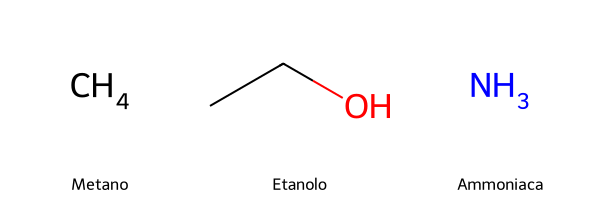

In [5]:
Draw.MolsToGridImage(mols, molsPerRow=3,subImgSize=(200,200), legends=[str(x) for x in mols_db['Specie']])

Aggiungendo gli atomi di H ed eseguendo una minimizzazione dell'energia in maniera semi-empirica, si possono anche rappresentare le strutture 3D delle molecole.

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Funzione che rappresenta la molecola
def viewmol(Specie):
  i = mols_db.loc[(mols_db == Specie).any(axis=1)].index[0]

  # Aggiunge gli atomi di H
  m = Chem.AddHs(mols[i])

  # Crea le coordinate Cartesiane
  AllChem.Compute2DCoords(m)
  AllChem.EmbedMolecule(m)

  # Esegue una semplice ottimizzazione di geometria
  AllChem.MMFFOptimizeMolecule(m)

  # Output delle info sulla geometria
  print(Chem.MolToMolBlock(m))

  # Rappresentazione 3D
  mblock = Chem.MolToMolBlock(m)
  view = py3Dmol.view(width=600, height=600)
  view.addModel(mblock, 'mol')
  view.setStyle('stick')
  view.zoomTo()
  view.show()

# Dropdown menù per la scelta della specie
interact(viewmol, Specie = mols_db['Specie']);

interactive(children=(Dropdown(description='Specie', options=('Metano', 'Etanolo', 'Ammoniaca'), value='Metano…

## **Calcolo dei descrittori**
La lista dei descrittori che può calcolare mordred si trova a [questo link](https://mordred-descriptor.github.io/documentation/master/descriptors.html). Nella cella seguente viene creato un `DataFrame` con questi descrittori: numero di atomi di H, C, O e N, le componenti principali del tensore d'inerzia, il raggio molecolare.

In [8]:
# Importa le categorie di descrittori da calcolare
from mordred import AtomCount, MomentOfInertia, GeometricalIndex

# Ottiene la struttura 3D di tutte le molecole
for i in range (0, len(mols)):
  mols[i] = AllChem.AddHs(mols[i])
  AllChem.EmbedMolecule(mols[i])
  AllChem.MMFFOptimizeMolecule(mols[i])

# Crea il calcolatore di descrittori
calc = Calculator()

# Aggiunge i descrittori da calcolare
calc.register(AtomCount.AtomCount(type='H')) # numero di atomi H
calc.register(AtomCount.AtomCount(type='C')) # numero di atomi C
calc.register(AtomCount.AtomCount(type='O')) # numero di atomi O
calc.register(AtomCount.AtomCount(type='N')) # numero di atomi N
calc.register(MomentOfInertia)               # le 3 compoenenti principali del tensore d'inerzia
calc.register(GeometricalIndex.Radius3D)     # il raggio molecolare

# Crea il DataFrame con i descrittori
descr = calc.pandas(mols)
display(descr)

100%|██████████| 3/3 [00:00<00:00, 43.56it/s]


nH  nC  nO  nN     MOMI-X     MOMI-Y     MOMI-Z  GeomRadius
0   4   1   0   0   3.206514   3.206514   3.206514    1.092199
1   6   2   1   0  60.758522  52.994409  15.181172    2.161249
2   3   0   0   1   2.670267   1.721465   1.721464    1.019000